<a href="https://colab.research.google.com/github/Noam-Coh3n/MLLM_practical/blob/main/practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
!pip install nnsight>0.5.0

clear_output()

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
# We set some seeds for reproducibility
import random
import torch

random.seed(12)
torch.manual_seed(12)
torch.cuda.manual_seed(12)

In [4]:
# utility function
def rindex(lst, value):
  """get the rightmost index of a value in a list."""
  return len(lst) - 1 - lst[::-1].index(value)

In [5]:
# We first of all import the model and (optionally) look at its internal structure
import nnsight
from IPython.display import clear_output

model = nnsight.LanguageModel("meta-llama/Llama-3.2-3B", device_map="auto")

clear_output()
# print(model)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split


In [7]:
from sklearn.metrics import accuracy_score
import gc

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df = pd.read_csv('/content/drive/MyDrive/us_cities_population.csv')
df.head()

,city,state,population,label
0,New York City,NY,8600000,1
1,Los Angeles,CA,4000000,1
2,Chicago,IL,2700000,1
3,Phoenix,AZ,1700000,1
4,Philadelphia,PA,1600000,1


In [10]:
print(df['population'])

0     8600000
1     4000000
2     2700000
3     1700000
4     1600000
       ...   
86      95000
87      90000
88      88000
89      88000
90      75000
Name: population, Length: 91, dtype: int64


In [11]:
PROMPT_TEMPLATE_POP = """Bend, OR, is a large city. This statement is: FALSE
Houston, TX, is a large city. This statement is: TRUE
{statement} This statement is:"""

source_statement_pop = "Los Angeles, CA, is a large city." # true
source_prompt_pop = PROMPT_TEMPLATE_POP.format(statement=source_statement_pop)
base_statement_pop = "Des Moines, IA, is a large city." # false
base_prompt_pop = PROMPT_TEMPLATE_POP.format(statement=base_statement_pop)

# False statement
print(base_prompt_pop)

Bend, OR, is a large city. This statement is: FALSE
Houston, TX, is a large city. This statement is: TRUE
Des Moines, IA, is a large city. This statement is:


In [12]:
import torch # Added import
from tqdm import trange # Import trange

predictions = []
all_logits = [] # Store all logits here

with torch.no_grad():
  for i in trange(len(df)):
    city = df.iloc[i]
    statement = f"{city.city}, {city.state}, is a large city."
    prompt = PROMPT_TEMPLATE_POP.format(statement=statement)

    with model.trace(prompt) as trace:
      logits = model.output.logits.save()
      all_logits.append(logits) # Append the logits to the list

    predictions.append(model.tokenizer.decode(logits.argmax(dim=-1)[0, -1]))

numeric_predictions = [1 if p == ' TRUE' else 0 for p in predictions]
acc = accuracy_score(df.label, numeric_predictions)

# Create a DataFrame to display the original labels and predictions
results_df = pd.DataFrame({'Actual Label': df.label, 'Predicted Label': numeric_predictions, 'City': df.city, 'state':df.state, 'pop':df.population})

# Filter for incorrect predictions
incorrect_predictions_df = results_df[results_df['Actual Label'] != results_df['Predicted Label']]


print(f"\n\nThe accuracy is: {acc}")

  0%|          | 0/91 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 91/91 [00:45<00:00,  1.99it/s]



The accuracy is: 0.8131868131868132


Analyzing the relationship between population and P(TRUE) - P(FALSE):
Fitted Linear Model: P(TRUE) - P(FALSE) = 0.4315 * log10(Population) + -2.4090


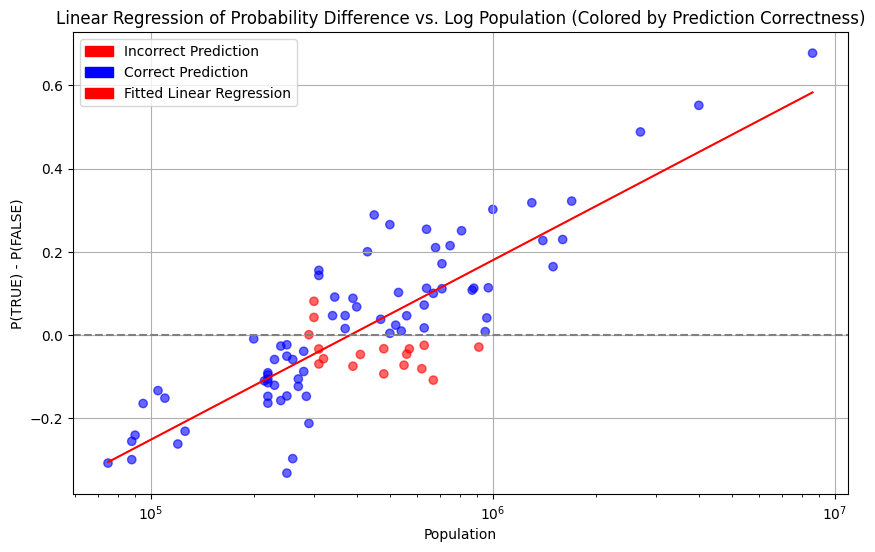

Estimated population cutoff where P(TRUE) ≈ P(FALSE): 382643


In [13]:
# Calculate probability differences and populations
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches # Import mpatches

print("Analyzing the relationship between population and P(TRUE) - P(FALSE):")

true_token_id = model.tokenizer(" TRUE").input_ids[1]
false_token_id = model.tokenizer(" FALSE").input_ids[1]

probability_diffs = []
populations = []

# Use the stored logits from the previous cell
for index, row in df.iterrows():
    logits = all_logits[index] # Get logits from the stored list

    # Calculate probabilities
    probs = logits[:, -1].softmax(dim=-1)
    true_prob = probs[0, true_token_id].item()
    false_prob = probs[0, false_token_id].item()

    probability_diffs.append(true_prob - false_prob)
    populations.append(row['population'])

# Create a DataFrame for analysis
prob_analysis_df = pd.DataFrame({'population': populations, 'prob_diff': probability_diffs})

# Sort by population for analysis and potential plotting (though only the regression plot will be shown)
prob_analysis_df = prob_analysis_df.sort_values(by='population')

# Fit a linear model to the probability difference vs. log population data

# Prepare the data for linear regression
# We will use the log of the population as the independent variable
# Add a small value to population to avoid log(0) if necessary, although populations are > 0 in this dataset
X = np.log10(prob_analysis_df['population'].values.reshape(-1, 1))
y = prob_analysis_df['prob_diff'].values

# Create and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X, y)

# Get the slope and intercept of the fitted line
slope = linear_model.coef_[0]
intercept = linear_model.intercept_

print(f"Fitted Linear Model: P(TRUE) - P(FALSE) = {slope:.4f} * log10(Population) + {intercept:.4f}")

# Predict the probability difference for a range of log populations
X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = linear_model.predict(X_pred)

# Convert log population back to population for plotting
population_pred = 10**X_pred

# --- Modification for coloring ---
# Merge prob_analysis_df with results_df to get prediction information
# Assuming 'population' is a common column or indices align
# A safer way is to merge based on city and state or index if they match
# Let's assume indices match for simplicity based on how they were generated
plot_data = prob_analysis_df.copy()
# Ensure the indices align before adding 'Actual Label' and 'Predicted Label'
# If the indices of prob_analysis_df were reset during sorting, we need to merge properly
# Let's re-create plot_data by merging on 'population' if it's unique, or on index if we are sure
# the original index order was preserved in prob_analysis_df before sorting.
# Based on the previous cell, prob_analysis_df was created from lists in original df order,
# then sorted. results_df was also created in original df order.
# To align them after sorting prob_analysis_df, merging is safer.

# Let's merge plot_data (which is sorted prob_analysis_df) with results_df
# We need to be careful about duplicates if any city has the same population and prob_diff
# A more robust way is to merge results_df into prob_analysis_df before sorting,
# or use the original df index if it was preserved.

# Let's go back to the state before sorting prob_analysis_df to ensure correct merging
# Re-calculate probability_diffs and populations without sorting prob_analysis_df initially for merging
probability_diffs_unsorted = []
populations_unsorted = []
for index, row in df.iterrows():
    logits = all_logits[index]
    probs = logits[:, -1].softmax(dim=-1)
    true_prob = probs[0, true_token_id].item()
    false_prob = probs[0, false_token_id].item()
    probability_diffs_unsorted.append(true_prob - false_prob)
    populations_unsorted.append(row['population'])

# Create an unsorted DataFrame for merging with results_df
unsorted_prob_analysis_df = pd.DataFrame({'population': populations_unsorted, 'prob_diff': probability_diffs_unsorted})

# Add original index to merge on
unsorted_prob_analysis_df['original_index'] = df.index
results_df['original_index'] = df.index

# Merge the dataframes on the original index
plot_data = pd.merge(unsorted_prob_analysis_df, results_df[['original_index', 'Actual Label', 'Predicted Label']], on='original_index')

# Now sort plot_data by population for consistent plotting with the regression line
plot_data = plot_data.sort_values(by='population')

# Determine colors based on correctness of prediction
colors = ['red' if row['Actual Label'] != row['Predicted Label'] else 'blue' for index, row in plot_data.iterrows()]
labels = ['Incorrect Prediction', 'Correct Prediction'] # Labels for legend
# Create custom legend handles
red_patch = mpatches.Patch(color='red', label='Incorrect Prediction')
blue_patch = mpatches.Patch(color='blue', label='Correct Prediction')


plt.figure(figsize=(10, 6))
# Scatter plot with colors based on correctness
plt.scatter(plot_data['population'], plot_data['prob_diff'], c=colors, alpha=0.6)

plt.plot(population_pred, y_pred, color='red', label='Fitted Linear Regression') # Keep the fitted line as red

plt.xlabel("Population")
plt.ylabel("P(TRUE) - P(FALSE)")
plt.title("Linear Regression of Probability Difference vs. Log Population (Colored by Prediction Correctness)")
plt.axhline(y=0, color='gray', linestyle='--', label='P(TRUE) - P(FALSE) = 0') # Add a line at 0 for reference
plt.xscale('log') # Set x-axis to logarithmic scale
plt.legend(handles=[red_patch, blue_patch, mpatches.Patch(color='red', label='Fitted Linear Regression')]) # Include custom patches and fitted line in legend
plt.grid(True)
plt.show()

    # We can also estimate the population where the model's prediction shifts from False to True
    # This is where P(TRUE) - P(FALSE) is approximately 0
    # 0 = slope * log10(Population) + intercept
    # log10(Population) = -intercept / slope
    # Population = 10^(-intercept / slope)
if slope != 0:
    estimated_cutoff_log = -intercept / slope
    estimated_cutoff_population = 10**estimated_cutoff_log
    print(f"Estimated population cutoff where P(TRUE) ≈ P(FALSE): {estimated_cutoff_population:.0f}")
else:
    print("Slope is zero, cannot estimate a cutoff population.")

In [14]:
#at this step, i need to save all_logits and predictions to cpu then free gpu#
# Move all_logits and predictions to CPU
all_logits_cpu = [logits.cpu() for logits in all_logits]
predictions_cpu = predictions # predictions is already a list of strings, no need to move

# Free GPU memory
import torch
import gc

del predictions
del all_logits

# Clear CUDA cache
gc.collect()
torch.cuda.empty_cache()

# Run garbage collection


print("GPU memory freed and data moved to CPU.")

GPU memory freed and data moved to CPU.


In [15]:
#in this cell, calculate activation on layer 8, token "large"#
LAYER = 8
large_token_id = model.tokenizer(' large').input_ids[1]

activations = []
# Loop through dataset
for i in trange(df.shape[0]):
  # Get the relevant row of the dataframe
  city = df.iloc[i]

  # Build the statement in the same format as the source and base statements
  statement = f"{city.city}, {city.state}, is a large city."

  # and put in the prompt
  prompt = PROMPT_TEMPLATE_POP.format(statement=statement)

  # Get the relevant token index
  prompt_token_ids = model.tokenizer(prompt).input_ids
  large_token_index = rindex(prompt_token_ids, large_token_id)

  # Get the model activations and append to the activations variable.
  with torch.no_grad():
    with model.trace(prompt) as trace:
      # get the model's activation at our chosen token & layer position
      activation = model.model.layers[LAYER].output[0][large_token_index, :].save()

      # add to our false/true activations!
    activations.append(activation.unsqueeze(0))

activations=torch.cat(activations)

100%|██████████| 91/91 [00:14<00:00,  6.40it/s]


In [16]:
all_activations = activations.detach().cpu().numpy()

In [17]:
import numpy as np

# Sigmoid function for you to use
def sigmoid(x):
  return 1/(1+np.exp(-x))


# Building the probe (1.5 pt)

# 0.5 pt
# First, write a function that takes a set of activations and a set of labels
# and returns the difference in means
def mm_diff(activations, labels):
  true_activations = activations[labels==1]
  false_activations = activations[labels==0]

  # Calculate the mean of the activations of true statements
  act_T = true_activations.mean(axis=0)

  # Calculate the mean of the activations of false statements
  act_F = false_activations.mean(axis=0)

  # Calculate the difference between them and return
  difference_in_means = act_T - act_F

  return difference_in_means

# 1 pt
# Write a classifier that takes activations, labels, and
# optionally the difference in means, and returns an array of true/false
# predictions corresponding to the given activations. Predictions can be in the
# form 1/0 or True/False
def mm_classifier(activations, labels, difference_in_means=None):
  # if the difference_in_means is given, use that, otherwise calculate it using
  # the function you wrote previously
  if difference_in_means is None:
    difference_in_means = mm_diff(activations, labels)

  # For the given activations, calculate their dot product with the difference_in_means
  # Calculate the sigmoid of the dot products
  # Predict True (or 1) if the sigmoid of the dot product is greater than 0.5,
  # else False (or 0).
  return sigmoid(np.dot(activations, difference_in_means)) > .5

In [18]:
#accuracy of mm probe on city population dataset#
all_pred_mm = mm_classifier(all_activations, df.label)
acc = accuracy_score(df.label, all_pred_mm)

print(f"Mean-mass probe trained on city population has accuracy {acc}")

Mean-mass probe trained on city population has accuracy 0.6593406593406593


In [19]:
#calculate the covariance of the dataset#
import numpy as np

# Assuming all_activations has been computed in a previous cell
# all_activations is expected to be a numpy array of shape (n_samples, n_features)

# Calculate the covariance matrix across features (columns)
covariance_matrix = np.cov(all_activations, rowvar=False, ddof=0) # rowvar=False to calculate covariance across columns (features), ddof=0 for population covariance

print("Covariance Matrix shape:")
print(covariance_matrix.shape)
print("\nCovariance Matrix (first 5x5):\n", covariance_matrix[:5, :5])

Covariance Matrix shape:
(3072, 3072)

Covariance Matrix (first 5x5):
 [[ 1.57280437e-04 -7.21988591e-05  1.81532004e-05  2.74137279e-05
   5.04912596e-06]
 [-7.21988591e-05  3.01970518e-04  4.24719331e-05 -6.92778871e-05
   9.52139479e-06]
 [ 1.81532004e-05  4.24719331e-05  8.15160579e-05  3.00317842e-05
  -2.82452694e-05]
 [ 2.74137279e-05 -6.92778871e-05  3.00317842e-05  1.53366285e-04
  -1.46783062e-05]
 [ 5.04912596e-06  9.52139479e-06 -2.82452694e-05 -1.46783062e-05
   9.39277410e-05]]


In [20]:
#modify the mean-mass probe with covariance matrix#

In [21]:
import numpy as np

# Sigmoid function for you to use
def sigmoid(x):
  return 1/(1+np.exp(-x))


# Building the probe (1.5 pt)

# First, write a function that takes a set of activations and a set of labels
# and optionally a covariance matrix, and returns the difference in means
def mm_diff_with_cov(activations, labels, covariance_matrix=None):
  true_activations = activations[labels==1]
  false_activations = activations[labels==0]

  # Calculate the mean of the activations of true statements
  act_T = true_activations.mean(axis=0)

  # Calculate the mean of the activations of false statements
  act_F = false_activations.mean(axis=0)

  # Calculate the difference between them
  difference = act_T - act_F

  # If covariance matrix is provided, weight the difference by the inverse covariance
  if covariance_matrix is not None:
    # Add a small value to the diagonal for numerical stability (regularization)
    reg_cov = covariance_matrix + np.eye(covariance_matrix.shape[0]) * 1e-6
    # Calculate the inverse of the covariance matrix
    inv_cov = np.linalg.inv(reg_cov)
    # Weight the difference
    difference_in_means = np.dot(inv_cov, difference)
  else:
    difference_in_means = difference


  return difference_in_means

# Write a classifier that takes activations, labels, and
# optionally the difference in means and covariance matrix, and returns an array of true/false
# predictions corresponding to the given activations. Predictions can be in the
# form 1/0 or True/False
def mm_classifier_with_cov(activations, labels, difference_in_means=None, covariance_matrix=None):
  # if the difference_in_means is given, use that, otherwise calculate it using
  # the function that incorporates the covariance matrix
  if difference_in_means is None:
    difference_in_means = mm_diff_with_cov(activations, labels, covariance_matrix=covariance_matrix)

  # For the given activations, calculate their dot product with the difference_in_means
  # Calculate the sigmoid of the dot products
  # Predict True (or 1) if the sigmoid of the dot product is greater than 0.5,
  # else False (or 0).
  return sigmoid(np.dot(activations, difference_in_means)) > .5

print("Modified mean-mass probe functions with covariance matrix support defined.")

Modified mean-mass probe functions with covariance matrix support defined.


In [22]:
#use the modified mm to caculate the accuracy#
# Assuming all_activations, df.label, and covariance_matrix are available from previous cells

# Use the modified mean-mass classifier with the covariance matrix
all_pred_mm_cov = mm_classifier_with_cov(all_activations, df.label, covariance_matrix=covariance_matrix)

# Calculate the accuracy
acc_cov = accuracy_score(df.label, all_pred_mm_cov)

print(f"Mean-mass probe trained with covariance matrix has accuracy {acc_cov}")

Mean-mass probe trained with covariance matrix has accuracy 1.0


In [23]:
#split the dataset into training and testing set, train the mm_cov with training dataset and test the accuracy on test set. the ratio of training and test is 8:2#
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming all_activations, df.label, and covariance_matrix are available from previous cells

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    all_activations, df.label, test_size=0.2, random_state=42
)

# Calculate the difference in means using the training data and the covariance matrix
# We need to recalculate the covariance matrix on the training data as well for a proper evaluation
# Calculate the covariance matrix across features (columns) for the training data
covariance_matrix_train = np.cov(X_train, rowvar=False, ddof=0)

difference_in_means_train = mm_diff_with_cov(X_train, y_train, covariance_matrix=covariance_matrix_train)

# Use the trained difference in means to make predictions on the test set
# We do not need to pass the covariance matrix to the classifier for prediction,
# as the weighting is already incorporated into the difference_in_means_train vector.
y_pred_test = mm_classifier_with_cov(X_test, y_test, difference_in_means=difference_in_means_train)

# Calculate the accuracy on the test set
acc_test = accuracy_score(y_test, y_pred_test)

print(f"Mean-mass probe trained on 80% of data and tested on 20% has accuracy: {acc_test}")

Mean-mass probe trained on 80% of data and tested on 20% has accuracy: 0.3157894736842105


In [24]:
#use same split, train unmodified mm probe on training set and test the accuracy of it on test set#
from sklearn.metrics import accuracy_score

# Assuming X_train, X_test, y_train, y_test are available from the previous cell
# Assuming the original mm_classifier and mm_diff functions are available from earlier cells

# Calculate the difference in means using the training data (unmodified mm_diff)
difference_in_means_train_unmodified = mm_diff(X_train, y_train)

# Use the unmodified mean-mass classifier to make predictions on the test set
y_pred_test_unmodified = mm_classifier(X_test, y_test, difference_in_means=difference_in_means_train_unmodified)

# Calculate the accuracy on the test set
acc_test_unmodified = accuracy_score(y_test, y_pred_test_unmodified)

print(f"Unmodified mean-mass probe trained on 80% of data and tested on 20% has accuracy: {acc_test_unmodified}")

Unmodified mean-mass probe trained on 80% of data and tested on 20% has accuracy: 0.6842105263157895


In [34]:
#Prompt-engineering: write a new prompt template to include the population of the city.#

PROMPT_TEMPLATE_POP_WITH_POPULATION = """Bend, OR, with a population of 100000, is a large city. This statement is: FALSE
Houston, TX, with a population of 2300000, is a large city. This statement is: TRUE
{statement} This statement is:"""

source_statement_pop = "Los Angeles, CA, with a population of 3800000, is a large city." # true
source_prompt_pop = PROMPT_TEMPLATE_POP_WITH_POPULATION.format(statement=source_statement_pop)
base_statement_pop = "Des Moines, IA, with a population of 210000, is a large city." # false
base_prompt_pop = PROMPT_TEMPLATE_POP_WITH_POPULATION.format(statement=base_statement_pop)

In [35]:
#In this cell, write code such that it uses the new prompt template to run the dataset with the model, collect predictions and calculate accuracy#
#should be 0.835, slightly bigger than prompt without number#


import torch # Added import
from tqdm import trange # Import trange

predictions = []

with torch.no_grad():
  for i in trange(len(df)):
    city = df.iloc[i]
    statement = f"{city.city}, {city.state}, with a population of {city.population} is a large city."
    prompt = PROMPT_TEMPLATE_POP_WITH_POPULATION.format(statement=statement)

    with model.trace(prompt) as trace:
      logits = model.output.logits.save()

    predictions.append(model.tokenizer.decode(logits.argmax(dim=-1)[0, -1]))

numeric_predictions = [1 if p == ' TRUE' else 0 for p in predictions]
acc = accuracy_score(df.label, numeric_predictions)



print(f"\n\nThe accuracy is: {acc}")

100%|██████████| 91/91 [00:23<00:00,  3.94it/s]



The accuracy is: 0.8351648351648352


In [56]:
source_activations = []
statement = "Jacksonville, FL, with a population of 960000, is a large city."
source_prompt_pop=PROMPT_TEMPLATE_POP_WITH_POPULATION.format(statement=statement)
with torch.no_grad():
  with model.trace(source_prompt_pop) as trace:
    for layer in model.model.layers:
      source_activations.append(layer.output[0].save())
    # save the model's output logits
    logits = model.output.logits.save()

# what's the model's response?
print(source_prompt_pop.split('\n')[-1])
print(model.tokenizer.decode(logits.argmax(dim=-1)[0, -1]))

Jacksonville, FL, with a population of 960000, is a large city. This statement is:
 TRUE


In [57]:
base_activations = []
statement = "Billings, MT, with a population of 110000, is a large city."
base_prompt_pop=PROMPT_TEMPLATE_POP_WITH_POPULATION.format(statement=statement)
with torch.no_grad():
  with model.trace(base_prompt_pop) as trace:
    # save the model's output logits
    logits = model.output.logits.save()

# what's the model's response?
print(base_prompt_pop.split('\n')[-1])
print(model.tokenizer.decode(logits.argmax(dim=-1)[0, -1]))

Billings, MT, with a population of 110000, is a large city. This statement is:
 FALSE


In [ ]:
print(source_activations)

In [58]:
#in this cell we can try patching, hypothesis is that the truth will be stored at number token#

# We run the model over the base prompt (false), replace activations with
# activations from the source prompt (true) and measure P(TRUE) - P(FALSE),
# i.e., does replace that token activation at that layer change the output towards TRUE?

# The below gets us the token ids of the tokens " TRUE" and " FALSE".
# Why do we do input_ids[1]?
# This is because when we give the tokenizer a string, it prepends the token ids
# of the string with a "beginning of sequence" token id. In this case it is 128000.
# If you print out the input_ids of any sequence, it will start with the token id 128000
true_token_id = model.tokenizer(" TRUE").input_ids[1]
false_token_id = model.tokenizer(" FALSE").input_ids[1]

# Here, we get the token ids of the source prompt
source_prompt_ids = model.tokenizer(source_prompt_pop).input_ids
base_prompt_ids=model.tokenizer(base_prompt_pop).input_ids
print(source_prompt_ids)
print(base_prompt_ids)
print(len(source_prompt_ids))
print(len(base_prompt_ids))
newline_token_id = model.tokenizer('\n').input_ids[1]
# And we find the start of the final example, i.e. the start of:
# "The city of Chicago is in Canada. This statement is:"
last_example_index = rindex(source_prompt_ids, newline_token_id) + 1 # get start of final example

patching_results = [] # save difference P(TRUE) - P(FALSE),
for layer_index in trange(model.config.num_hidden_layers): # loop through layers
  patching_per_layer = []
  for token_index in range(last_example_index, len(source_prompt_ids)): # loop through tokens of the final example
    with torch.no_grad():
      with model.trace(base_prompt_pop):
        # We get the activation of the model for the current layer and token,
        # and replace it with the equivalent activation from the source prompt.
        model.model.layers[layer_index].output[0][token_index, :] = source_activations[layer_index][token_index, :]
        # get model output and convert to probabilities using softmax
        patched_probs = model.output.logits[:, -1].softmax(dim=-1)
        # get probability of generating true vs. false answer
        patched_true_prob = patched_probs[0, true_token_id].item()
        patched_false_prob = patched_probs[0, false_token_id].item()
        # save difference btw true & false answers
        patched_diff = patched_true_prob - patched_false_prob
        patching_per_layer.append(patched_diff.save())
  patching_results.append(patching_per_layer)

[128000, 33, 408, 11, 2794, 11, 449, 264, 7187, 315, 220, 1041, 931, 11, 374, 264, 3544, 3363, 13, 1115, 5224, 374, 25, 7989, 198, 79894, 11, 17467, 11, 449, 264, 7187, 315, 220, 9870, 931, 15, 11, 374, 264, 3544, 3363, 13, 1115, 5224, 374, 25, 8378, 198, 62382, 8078, 11, 13062, 11, 449, 264, 7187, 315, 220, 16415, 931, 11, 374, 264, 3544, 3363, 13, 1115, 5224, 374, 25]
[128000, 33, 408, 11, 2794, 11, 449, 264, 7187, 315, 220, 1041, 931, 11, 374, 264, 3544, 3363, 13, 1115, 5224, 374, 25, 7989, 198, 79894, 11, 17467, 11, 449, 264, 7187, 315, 220, 9870, 931, 15, 11, 374, 264, 3544, 3363, 13, 1115, 5224, 374, 25, 8378, 198, 28576, 826, 11, 19629, 11, 449, 264, 7187, 315, 220, 5120, 931, 11, 374, 264, 3544, 3363, 13, 1115, 5224, 374, 25]
71
71


100%|██████████| 28/28 [02:33<00:00,  5.47s/it]


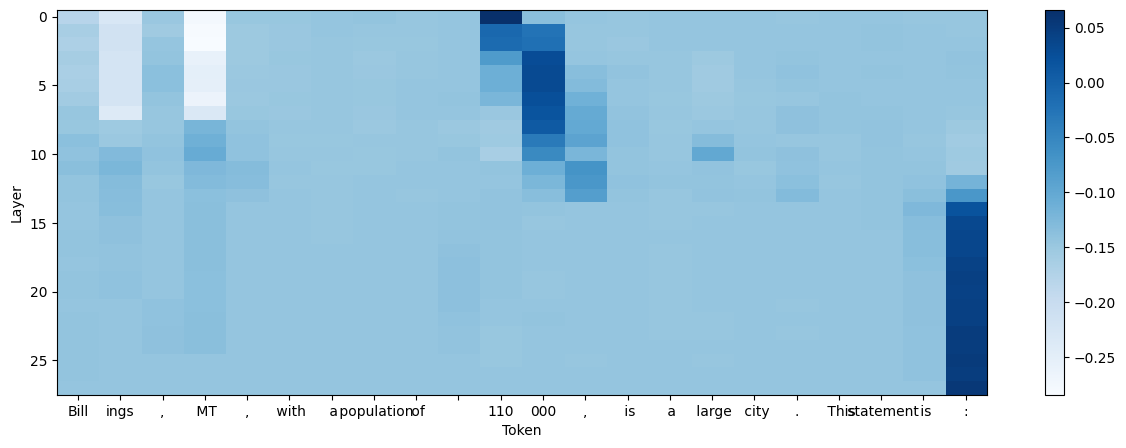

In [59]:
#If we add the population number into prompt, we can see a dark shade at the number token in activation patching#
#numbers are tokenized into several 3-digits tokens, so if we have 1milion vs 100k, activation pathcing wont work cuz the tokens are not of same length#
#Here I lied in the source/base prompt on the population of the two cities to make activation patching work#
# The model has a internal bielief that a large city should have at least 300k population.#
# In activation patching we can see that the tokens of numbers store more information thant token 'large'#

import matplotlib.pyplot as plt

base_token_ids = model.tokenizer(base_prompt_pop).input_ids
token_strings = [
  f"{model.tokenizer.decode(base_token_ids[t])}"
  for i, t in enumerate(range(last_example_index, len(base_token_ids)))
]

fig, ax = plt.subplots(figsize=(15,5))
pop_plot = ax.imshow(patching_results, aspect='auto', cmap='Blues', interpolation='none')

# Setting plot details
ax.set_xticks(range(len(base_token_ids)-last_example_index))
ax.set_xticklabels(token_strings)
ax.set_ylabel('Layer')
ax.set_xlabel('Token')
fig.colorbar(pop_plot)
plt.show()